### Úvod
Uvažujte model hromadné obsluhy $M|G|\infty$.

* Požadavky přichází podle Poissonova procesu s intenzitou $\lambda = 10 \mathrm{s}^{-1}$.

* Doba obsluhy jednoho požadavku (v sekundách) má rozdělení $S\sim\mathrm{Ga}(4,2)$, tj. Gamma s parametry _a_ = 4, _p_ = 2.

* Časy mezi příchody a časy obsluhy jsou nezávislé.

* Systém má (teoreticky) nekonečně paralelních obslužných míst (každý příchozí je rovnou obsluhován).

Označme $N_t$ počet zákazníků v systému v čase _t_. Předpokládejme, že na začátku je systém prázdný, tj. $N_0$ = 0.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats as st

### **1) Simulujte jednu trajektorii $\{N_t(\omega) \mid t\in(0,10~\mathrm{s})\}$. Průběh trajektorie graficky znázorněte.**

#### V postupu jsme vycházeli z věty 19.6
<img src="../img/lemma_19.6.png" width="60%"/>

Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-23-Handout.pdf">NI-VSM-Lec-23-Handout</a>, strana 4

Vygenerujeme si tedy **n** (počet zákazníků) z poissonova rozdělení -> **~ Poisson(lambda * t)**

Následně vygenerujeme časy z uniformního rozdělení **~ Unif(0, t)**, časy seřadíme a tím dostaneme časy příchodů Poissonova procesu.

Doby obsluhy vygenerujeme již normálně za pomoci zadaných parametrů gamma rozdělení.

In [2]:
# zadane hodnoty
t = 10
lambda1 = 10
scale = 1/4 # numpy.random.gamma pouziva theta namisto a, plati theta=1/a
shape = 2

In [3]:
def get_trajectory(t, customer_count):
    customer_arrival_times = np.random.uniform(0, t, customer_count)  # viz veta 19.6
    customer_arrival_times = np.sort(customer_arrival_times)
    
    processing_times = np.random.gamma(shape, scale, customer_count)  # trvani obsluhy jednotlivych pozadavku
    customer_leave_times = customer_arrival_times + processing_times
    
    event_times = np.sort(np.concatenate([[0], customer_arrival_times, customer_leave_times]))
    
    # priprava hodnot zachycujici vyvoj zmen poctu zakazniku v danem case
    customer_count_changes = [0]  # protoze v case 0 jich tam je 0
    for index, event_time in enumerate(event_times):
        if index == 0:
            continue
        if event_time in customer_arrival_times:
            customer_count_changes.append(1)
        else:
            customer_count_changes.append(-1)
        
    trajectory = np.cumsum(customer_count_changes)  # pocet zakazniku v danem case    
    event_times = event_times[event_times<=t]  # chceme pouze casy do t vterin
    
    return event_times, trajectory[:len(event_times)]

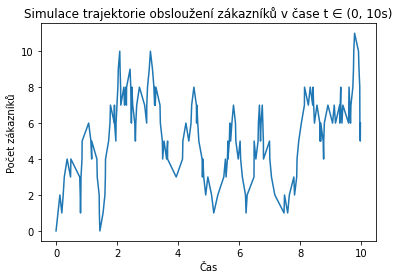

In [4]:
customer_count = np.random.poisson(lambda1 * t)  # vygeneruji, kolik zakazniku ma prijit
event_times, trajectory = get_trajectory(t, customer_count)

# plt.scatter(event_times, trajectory)
plt.plot(event_times, trajectory)
plt.title('Simulace trajektorie obsloužení zákazníků v čase t ∈ (0, 10s)')
plt.xlabel('Čas')
plt.ylabel('Počet zákazníků')
plt.show()

### **2) Simulujte $n = 500$ nezávislých trajektorií pro $t\in(0,100)$. Na základě těchto simulací odhadněte rozdělení náhodné veličiny $N_{100}$.**

Nejprve si vygenerujme 500 nezavislych trajektorii pro $t\in(0,100)$. K tomu vyuzijeme kod z prvni casti ukolu. Funkce `get_trajectory` nam rovnou vraci i pocet obsluhovanych zakazniku v konkretnim case. Z techto trajektorii vezmeme pocet prave obsluhovanych zakazniku v case $N_{100}$ a vyneseme do histogramu.

In [15]:
traj_cnt = 500
t = 100

event_times = []
trajectories = []
for _ in range(traj_cnt):
    customer_count = np.random.poisson(lambda1 * t)
    event_t, traj = get_trajectory(t, customer_count)
    trajectories.append(traj)
    event_times.append(event_t)


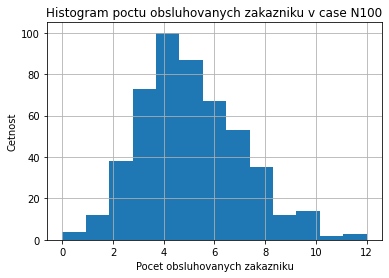

In [16]:
last = pd.Series([trajectory[-1] for trajectory in trajectories])
last.hist(bins=len(last.unique()));
plt.title(f'Histogram poctu obsluhovanych zakazniku v case N100')
plt.ylabel('Cetnost')
plt.xlabel('Pocet obsluhovanych zakazniku')
plt.show()

Vime, ze rozdeleni Gamma(a,p) ma stredni hodnotu $\mu=\frac{a}{p} = 2$. Zaroven take vime, ze podle principu deleni nehomogenniho Poissonova procesu bude pocet zakazniku v case $t\to+\infty$ NV s rozdelenim **~Poisson($\frac{\lambda}{\mu}$)** (viz https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-23-Handout.pdf)

Muzeme nyni uvazovat, ze doba behu trajektorii $t = 100s$ je dostatecne dlouha na to, abychom mohli ocekavat, ze napozorovane vysledky $N_{100}$ budou mit priblizne rozdeleni jako v case $t\to+\infty$, tedy ~Poisson($\frac{\lambda}{\mu}$). Pokud si tedy vygenerujeme stejne velky vzorek n=500 z rozdeleni Poisson($\frac{\lambda}{\mu})$, meli bychom ziskat priblizne stejny histogram jako z napozorovanych hodnot $N_{100}$.

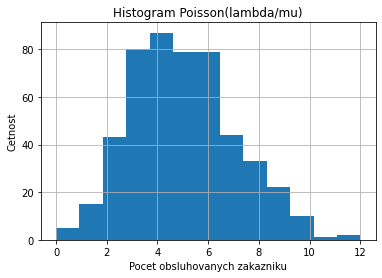

In [17]:
mu = (1/scale)/shape
poisson = pd.Series(np.random.poisson(lambda1/mu, traj_cnt))

poisson.hist(bins=len(poisson.unique()));

plt.title(f'Histogram Poisson(lambda/mu)')
plt.ylabel('Cetnost')
plt.xlabel('Pocet obsluhovanych zakazniku')
plt.show()

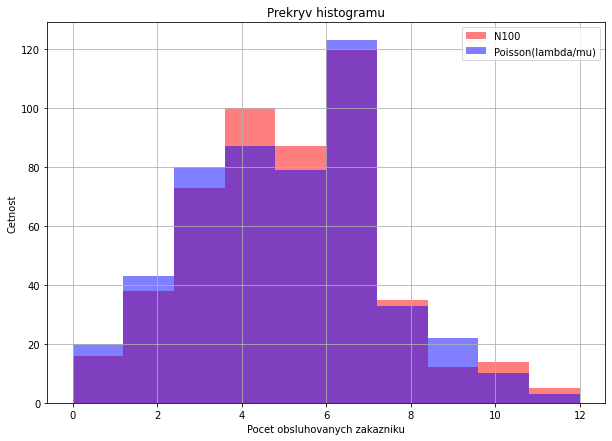

In [18]:
last.hist(fc=(1, 0, 0, 0.5), label = 'N100', figsize=(10,7));
pd.Series(poisson).hist(fc=(0, 0, 1, 0.5), label = 'Poisson(lambda/mu)', figsize=(10,7));

plt.title(f'Prekryv histogramu')
plt.ylabel('Cetnost')
plt.xlabel('Pocet obsluhovanych zakazniku')
plt.legend()
plt.show()

Posledni graf zobrazuje prekryv obou histogramu. Fialova cast je spolecna pro oba procesy, oranzova oznacuje vyssi cetnost hodnoty v $N_{100}$, modra zase v rozdeleni Poisson($\frac{\lambda}{\mu})$.

Z tohoto grafu lze odhadnout, ze podle prekryvu obou histogramu mohou mit vygenerovane hodnoty pro $N_{100}$ byt z rozdeleni ~Poisson($\frac{\lambda}{\mu})$, tedy ~Poisson(5).

### **3) Diskutujte, jaké je limitní rozdělení tohoto systému pro $t\to+\infty$ (vizte přednášku 23.). Pomocí vhodného testu otestujte na hladině významnosti $5~\%$, zda výsledky simulace $N_{100}$ odpovídají tomuto rozdělení.**

Ze zadání máme obecně proces $(M|G|\infty)$. Příchody se řídí Poissonovým processem s intenzitou λ. Čas obsluhy má neznámé rozdělení $F_S$, takové že $E S= 1/μ$. Zákazník je obsluhován okamžitě po příchodu, nikdo nečeká ve frontě.

Pokud budeme uvažovat $t \rightarrow \infty$, dosáhne poissonova rozdělení s parametrem $\dfrac{\lambda}{\mu}$, viz následující tvrzení z přednášky

<img src="../img/M-G-INFTY-dlouhodobe-hledisko.png" width="60%"/>
Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-23-Handout.pdf">NI-VSM-Lec-23-Handout</a>, strana 9/10.
<br><br>

V našem zadání máme parametry $\lambda = 10$ a $\mu = \dfrac{4}{2} = 2$ (viz předchozí podúkol). Tedy $\dfrac{\lambda}{\mu} = 5$

Zda simulace $N_{100}$ odpovídá rozdělení $Poission(5)$ otestujeme pomocí $\chi^2$ testu při známých parametrech, viz

<img src="../img/chi_square_test.png" width="50%"/>
Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-12-Handout.pdf">NI-VSM-Lec-12-Handout</a>, strana 3/8.

Hypotézy jsou 
* $H_0$ Výsledky simulace $N_{100}$ odpovídají rozdělení $Poisson(5)$
* $H_{A}$ Výsledky simulace $N_{100}$ neodpovídají rozdělení $Poisson(5)$

In [9]:
# vypocet teoreticke cetnosti pro vygenerovane hodnoty

teoreticke_rozdeleni = st.poisson(mu=5)
n = len(poisson)

dfc = pd.DataFrame(pd.Series(poisson).value_counts(), columns=['namerene cetnosti']).reset_index().rename({'index': 'hodnota'}, axis=1).sort_values(by='hodnota').reset_index(drop=True)
dfc['teoreticke pts'] = dfc.hodnota.apply(lambda hodnota:  teoreticke_rozdeleni.pmf(k=hodnota)) 

# musime jeste pridat pts, ze teoreticka cetnost je mimo vygenerovane cetnosti
# pridame tedy doplnek 1 - sum(teoreticke cetnosti)
dfc = dfc.append({'hodnota': '>= 14', 'namerene cetnosti': 0, 'teoreticke pts': 1 - sum(dfc['teoreticke pts'])}, ignore_index=True)

# dfc['teoreticke cetnosti'] = dfc.hodnota.apply(lambda hodnota: n * teoreticke_rozdeleni.pmf(k=hodnota))
dfc['teoreticke cetnosti'] = n * dfc['teoreticke pts']
display(dfc)
print(f'Suma teoretickych pts: {sum(dfc["teoreticke pts"])}')

,hodnota,namerene cetnosti,teoreticke pts,teoreticke cetnosti
0,0,4,0.006738,3.368973
1,1,15,0.033690,16.844867
2,2,47,0.084224,42.112169
3,3,70,0.140374,70.186948
4,4,90,0.175467,87.733685
5,5,87,0.175467,87.733685
6,6,73,0.146223,73.111404
7,7,48,0.104445,52.222431
8,8,28,0.065278,32.639020
9,9,17,0.036266,18.132789


Suma teoretickych pts: 1.0


In [10]:
# aby platilo, ze teoreticke cetnosti jsou >= 5, spojime hodnoty [0,1] a [11, 12, 13, 14]

dfc.loc[11, 'namerene cetnosti':] = dfc.loc[11:, 'namerene cetnosti':].sum()
dfc.loc[11, 'hodnota'] = ">=11"
dfc = dfc.drop(dfc.index[12:])

dfc.loc[1, 'namerene cetnosti':] = dfc.loc[0:1, 'namerene cetnosti':].sum()
dfc.loc[1, 'hodnota'] = "0+1"
dfc = dfc.drop(0)

display(dfc)
print(f'Suma teoretickych pts: {sum(dfc["teoreticke pts"])}')

,hodnota,namerene cetnosti,teoreticke pts,teoreticke cetnosti
1,0+1,19.0,0.040428,20.213841
2,2,47.0,0.084224,42.112169
3,3,70.0,0.140374,70.186948
4,4,90.0,0.175467,87.733685
5,5,87.0,0.175467,87.733685
6,6,73.0,0.146223,73.111404
7,7,48.0,0.104445,52.222431
8,8,28.0,0.065278,32.639020
9,9,17.0,0.036266,18.132789
10,10,10.0,0.018133,9.066394


Suma teoretickych pts: 1.0


In [11]:
# pouziti testu
alpha = 0.05
k = len(dfc.index)
print(f'Pouzijeme chi2 s parametry alpha={alpha}, k={k}\n')
statistika = sum((dfc['namerene cetnosti'] - dfc['teoreticke cetnosti']).pow(2) / dfc['teoreticke cetnosti'])
chi2 = st.chi2.isf(alpha, k-1)

print(f'Testová statistika: {statistika}')
print(f'chi2: ', chi2)
print("Je Chi2 (testová statistika) >= chi2 (kriticka hodnota) ? ->", statistika >= chi2)

Pouzijeme chi2 s parametry alpha=0.05, k=11

Testová statistika: 4.391180816461718
chi2:  18.30703805327515
Je Chi2 (testová statistika) >= chi2 (kriticka hodnota) ? -> False


Podle výsledku testu nezamítáme $H_0$, tedy že výsledky simulace $N_{100}$ odpovídají rozdělení $Poisson(5)$.